# Guidance for generating prior information.
1. load image

In [1]:
from skimage.data import astronaut
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import skimage

image = img_as_float(astronaut()[::2, ::2])
image = resize(image, (299, 299))

Of course, you can use your own picture.

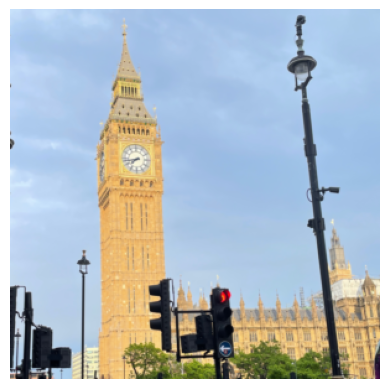

In [2]:
import skimage
pic = skimage.io.imread('data/bigBen.jpeg')
pic = img_as_float(pic)
pic = resize(pic, (299, 299))
pic = np.array([pic])

plt.axis('off')
plt.imshow(pic[0])
plt.show()


2. label the super pixels。

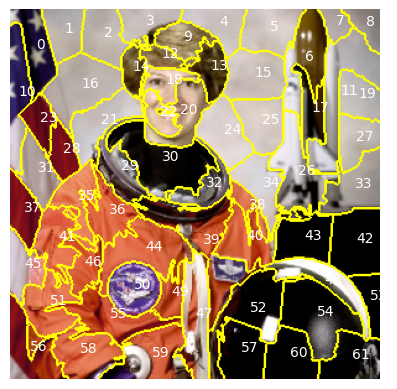

In [3]:
from skimage.segmentation import slic
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries



# Define the segmentation method
segments = slic(image, n_segments=100)

def tab_superpixel(segments,image):


    #get centre for each super pixels
    props = regionprops(segments)
    centers = [prop.centroid for prop in props]

    # mark indexes
    for i, center in enumerate(centers):
       plt.annotate(str(i), (center[1], center[0]), color='white')
    plt.imshow(mark_boundaries(image,segments))
    plt.axis('off')
    plt.show()

tab_superpixel(segments,image)

3. check if you have chosen the right indexes.

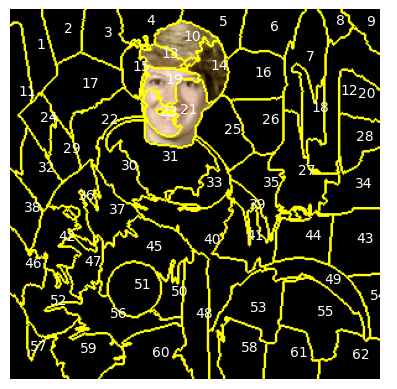

In [4]:
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt


# The important super pixels ordered by their importance.
prior = [10,14,13,21,23,19]  


def verify(segments,image):

    # Replace with the segment numbers you want to keep
    mask = np.zeros_like(segments)
    for seg in prior:
        mask[segments == seg] = 1

    # Apply the mask to the image
    masked_image = image * mask[:, :, np.newaxis]

    # Create a boundary image
    boundary_image = mark_boundaries(masked_image, segments)

    props = regionprops(segments)
    centers = [prop.centroid for prop in props]


    for i, center in enumerate(centers):
        plt.annotate(str(i+1), (center[1], center[0]), color='white')
    # Display the result
    plt.imshow(boundary_image)
    plt.axis('off')
    plt.show()

verify(segments,image)

4. Generate your prior knowledge.

In [5]:
# please note the array will not be the final result !!!
def prior_csv(prior,segments):
   segmentation_n = np.amax(segments)
   level = 1/(len(prior)+1)
   csv = [0 for i in range(segmentation_n)]
   for index,item in enumerate(prior):
      csv[item-1] = level*(len(prior)-index)
   return csv

prior_csv(prior,segments)


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.8571428571428571,
 0,
 0,
 0.5714285714285714,
 0.7142857142857142,
 0,
 0,
 0,
 0,
 0.14285714285714285,
 0,
 0.42857142857142855,
 0,
 0.2857142857142857,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

5. mutiple coefficient for keeping balance.

In [6]:
from lime import lime_image
from keras.applications import inception_v3 as inc_net
import pandas as pd

# Define a classifier
inet_model = inc_net.InceptionV3()

def prior_csv_final(model,prior,segments):
   explainer = lime_image.LimeImageExplainer()
   explanation = explainer.explain_instance(image, model.predict, top_labels=5, hide_color=0, num_samples=100)
   max_coe = explanation.local_exp[explanation.top_labels[0]][0][1]
   csv = pd.DataFrame([max_coe* i for i in prior_csv(prior,segments)])
   csv.to_csv('prior.csv',index=False,header=False)
   return csv
   

prior_csv_final(inet_model,prior,segments)


2023-04-16 16:55:18.013149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 16:55:25.011951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 909ms/step


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
57,0.0
58,0.0
59,0.0
60,0.0
